# Employment by Regions in Georgia

Data sources:
- Statistical data of the Labour Force Indicators by Regions of Georgia is retrieved on Jun 1, 2022 from the website of the National Statistics Office of Georgia: [geostat.ge](https://www.geostat.ge/en/)
- Map data of the borders of the administrative areas of Georgia (GADM data v4.0 for Georgia in `Shapefile` format) is retrieved on Jun 1, 2022 from the GADM website: [gadm.org](https://gadm.org)


In [1]:
from datetime import datetime, timedelta
nb_st = datetime.utcnow()
print(f"\nNotebook START time: {nb_st} UTC\n")


Notebook START time: 2022-06-02 14:20:47.658505 UTC



In [2]:
%%HTML
<script>
  function code_toggle() {
    if (code_shown){
      $('div.input').hide('500');
      $('#toggleButton').val('Show Python Code')
    } else {
      $('div.input').show('500');
      $('#toggleButton').val('Hide Python Code')
    }
    code_shown = !code_shown
  }

  $( document ).ready(function(){
    code_shown=false;
    $('div.input').hide();
    $('div.input:contains("%%HTML")').removeClass( "input")
  });
</script>
<form action="javascript:code_toggle()"><input type="submit" id="toggleButton" value="Show Python Code"></form>


In [3]:
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
def read_employment_data_of_year(year, target_feature, excel_path = "data/05-Labour-Force-Indicators-by-regions.xlsx"):
    df = pd.read_excel(excel_path)
    df = df.loc[df.index >= df.loc[df.iloc[:,0] == year].index.item()]
    col_names = df.head(2).tail(1).values
    df = df.loc[df.iloc[:,0] == target_feature].head(1)
    df.columns = col_names[0]
    df = df.T.reset_index()
    df.columns = ['Region', target_feature]
    df = df.dropna()
    df = df.sort_values(by=target_feature, ascending=True)
    return df

In [5]:
features_available = [
    'Total 15 + population',  # 0
    'Labour force',  # 1
    'Employed',  # 2
    'Hired',  # 3
    'Self-employed',  # 4
    'Not-identified worker',  # 5
    'Unemployed',  # 6
    'Population outside labour force',  # 7
]
year, target_feature = 2021, features_available[3]
df = read_employment_data_of_year(year, target_feature)
print(f"\nData for {year} year:\n")
display(df)


Data for 2021 year:



,Region,Hired
11,Racha-Lechkhumi and Kvemo-Svaneti,7.102363
9,Guria,17.835517
10,Mtskheta-Mtianeti,21.370056
8,Samtskhe-Javakheti,30.006213
3,Shida Kartli,51.550302
1,Kakheti,56.537744
6,Samegrelo-Zemo Svaneti,58.569218
4,Kvemo Kartli,76.423655
5,Adjara A/R,80.63719
7,Imereti,101.9573


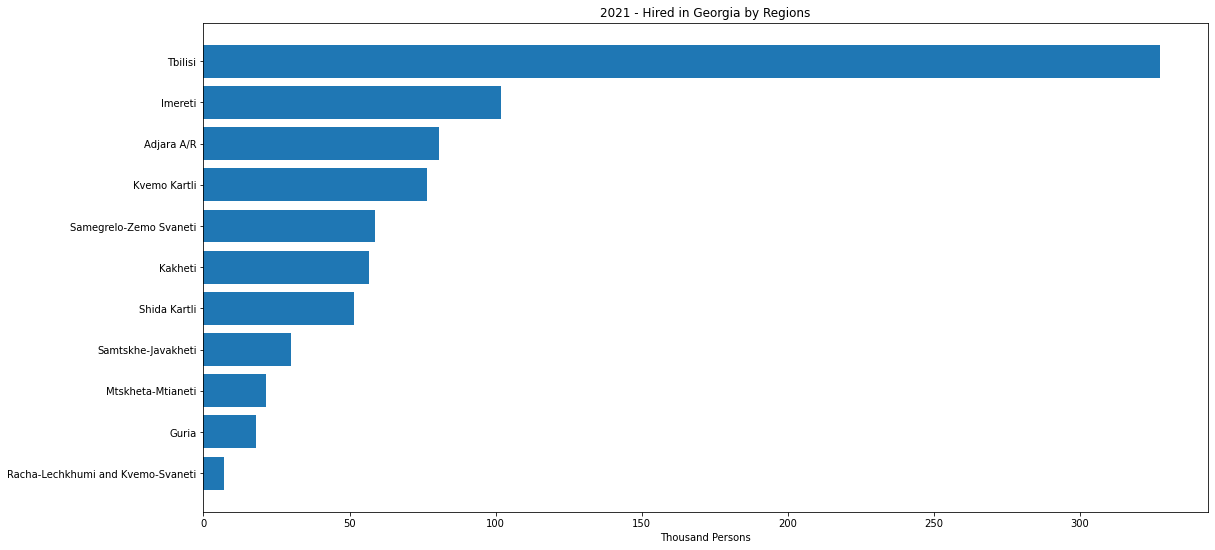

In [6]:
plt.figure(figsize=(18,9))
plt.barh(data=df.loc[df['Region'] !='Georgia'], y='Region', width=target_feature)
plt.title(f'{year} - {target_feature} in Georgia by Regions')
plt.xlabel('Thousand Persons')
plt.show()

In [7]:
import geopandas

In [8]:
Georgia_geodf = geopandas.read_file('data/GADM/gadm40_GEO_shp/gadm40_GEO_1.shp')

In [9]:
print(Georgia_geodf['NAME_1'].unique())

['Abkhazia' 'Ajaria' 'Guria' 'Imereti' 'Kakheti' 'Kvemo Kartli'
 'Mtskheta-Mtianeti' 'Racha-Lechkhumi-Kvemo Svaneti'
 'Samegrelo-Zemo Svaneti' 'Samtskhe-Javakheti' 'Shida Kartli' 'Tbilisi']


In [10]:
print('Check if there is any mismatch in region names between data and map:')
df.set_index('Region').index.difference(Georgia_geodf['NAME_1'].unique())

Check if there is any mismatch in region names between data and map:


Index(['Adjara A/R', 'Georgia', 'Racha-Lechkhumi and Kvemo-Svaneti'], dtype='object', name='Region')

In [11]:
print('Resolving name mismatch detected earlier in order to connect employment data to map data...')
df = df.replace({'Adjara A/R':'Ajaria', 'Racha-Lechkhumi and Kvemo-Svaneti':'Racha-Lechkhumi-Kvemo Svaneti'})

Resolving name mismatch detected earlier in order to connect employment data to map data...


In [12]:
print('Checking if mismatch is resolved (expecting no region names):')
df.set_index('Region').index.difference(Georgia_geodf['NAME_1'].unique())

Checking if mismatch is resolved (expecting no region names):


Index(['Georgia'], dtype='object', name='Region')

In [13]:
merged_geodf = Georgia_geodf.merge(df, left_on='NAME_1', right_on='Region', how='left').fillna(0)
print(f"Map data with statistics for the {len(Georgia_geodf['NAME_1'].unique())} regions is ready.")

Map data with statistics for the 12 regions is ready.


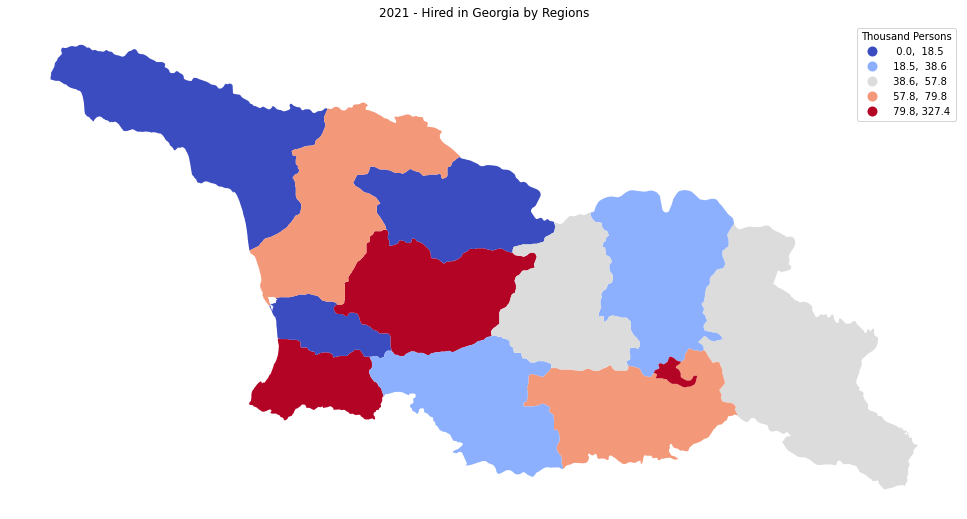

In [14]:
merged_geodf.plot(
    column=target_feature,
    scheme="Quantiles",
    figsize=(18, 9),
    legend=True,
    legend_kwds = {"fmt": "{:.1f}", "title": "Thousand Persons"},
    cmap='coolwarm'
)
plt.gca().set_axis_off()
plt.title(f'{year} - {target_feature} in Georgia by Regions')
plt.show()

In [15]:
print(f"\n ** Total Elapsed time: {datetime.utcnow() - nb_st} ** \n")
print(f"Notebook END time: {datetime.utcnow()} UTC\n")


 ** Total Elapsed time: 0:00:01.674144 ** 

Notebook END time: 2022-06-02 14:20:49.332731 UTC




*This notebook is originally published under the Apache License (Version 2.0) at the following GitHub repository: [sentinel-1/employment_map_Georgia](https://github.com/sentinel-1/employment_map_Georgia)*

For the issues, feedback or suggestions regarding the original notebook (if any) feel free to open an issue at the corresponding [Issues page of the repository](https://github.com/sentinel-1/employment_map_Georgia/issues)